In [123]:
import os
import numpy as np
import random
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path

import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, Subset

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"running on {device}")

def set_seeds():
    torch.manual_seed(42)
    torch.cuda.manual_seed(42)

running on cpu


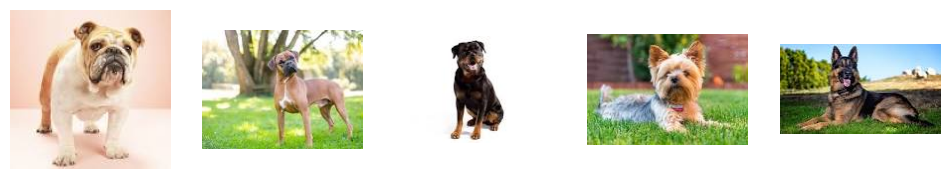

In [112]:
img_folder = Path("C:/Users/Daniel/Documents/dataset/image-datasets/classification/dog-breed-images/dataset")

# view random images
nrows = 1
ncols = 5
# random_img = random.r
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize = (12, 9 ))
for i in range(ncols):
    cat = random.randint(0, len(os.listdir(img_folder))-1)
    img_idx = random.randint(0, len(os.path.join(img_folder, f"{cat}"))-1)
    class_path = os.path.join(img_folder, f"{cat}")
    img_path = os.path.join(class_path, os.listdir(class_path)[img_idx])
    img = np.array(Image.open(img_path))
    axs[i].imshow(img)
    axs[i].axis(False)

In [124]:
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

# create dataset for images
dataset = ImageFolder(img_folder, transform=transform)
len(dataset)

967

In [156]:
data_len = len(dataset)
idx = torch.randperm(len(dataset))
train_size = int(0.7 * data_len)

train_dataset = Subset(dataset, idx[:train_size])
test_dataset = Subset(dataset, idx[train_size:])

print(f"train size: {len(train_dataset)} \ntest size: {len(test_dataset)}")

BATCH_SIZE = 4
train_dataloader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True, num_workers=os.cpu_count())
test_dataloader = DataLoader(train_dataset, BATCH_SIZE, num_workers=os.cpu_count())

train size: 676 
test size: 291


In [126]:
images, labels = next(iter(train_dataloader))

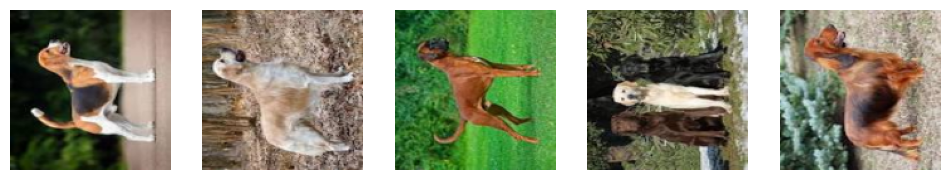

In [140]:
samples = torch.randint(0, len(images), size=[5])

# plot images from dataloader
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize = (12, 9 ))
for i,sample in enumerate(samples):
    img = images[sample].permute(2,1,0)
    axs[i].imshow(img)
    axs[i].axis(False)

In [149]:
## model definition
class DogClassifier(nn.Module):
    def __init__(self, in_channels:int=3, num_classes:int=10, hidden_units=64):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=hidden_units, kernel_size=(5,5)),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=(5,5)),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=(3,3)),
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*118*118, out_features=16),
            nn.Linear(in_features=16, out_features=8),
            nn.Linear(in_features=8, out_features=num_classes)
        )

    def forward(self, x):
        return (self.layer_stack(x))
        
model = DogClassifier()
model

DogClassifier(
  (layer_stack): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
    (1): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1))
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): Flatten(start_dim=1, end_dim=-1)
    (4): Linear(in_features=891136, out_features=16, bias=True)
    (5): Linear(in_features=16, out_features=8, bias=True)
    (6): Linear(in_features=8, out_features=10, bias=True)
  )
)

In [152]:
dummy = torch.rand((1,3,128,128))
torch.sigmoid(model(dummy))

tensor([[0.5462, 0.5881, 0.5443, 0.5226, 0.5387, 0.4127, 0.4713, 0.6092, 0.5312,
         0.4130]], grad_fn=<SigmoidBackward0>)

In [157]:
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
criterion = CrossEntropyLoss()
opt = Adam(params=model.parameters(), lr=1e-2)

In [158]:
def accuracy(y_train, y_truth):
    acc = torch.eq(y_train, y_truth).sum().item()
    return (acc / len(y_truth)) * 100

accuracy(torch.rand(5).round(), torch.rand(5).round())

80.0

In [159]:
# training loop
EPOCHS = 1
history = {}
for epoch in range(EPOCHS):
    train_loss, train_acc = 0, 0

    model.train()
    for batch, (X_train, y_train) in enumerate(train_dataloader):
        X_train, y_train = X_train.to(device), y_train.to(device)

        output = model(X_train) # forward pass

        loss = criterion(output, y_train)

        train_loss += loss
        train_acc += accuracy(torch.argmax(output), y_train)

        opt.zero_grad() # revent gradients from accumulating
        loss.backward()
        opt.step()
    
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)

    model.eval()
    with torch.inference_mode():
        test_loss, test_acc = 0,0
        for X_test, y_test in test_dataloader:
            X_test, y_test = X_test.to(device), y_test.to(device)

            test_output = model(X_test)

            loss = criterion(test_output, y_test)

            test_loss += loss
            test_acc += accuracy(torch.argmax(output), y_test)
        
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
    
        
    print(f"[{epoch + 1}/{EPOCHS}] | train_loss: {train_loss} | train_acc: {train_acc} | test_loss: {test_loss} | test_acc: {test_acc}")

[1/1] | train_loss: 6222.45361328125 | train_acc: 2.662721893491124 | test_loss: 48.1349983215332 | test_acc: 10.207100591715976
